In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('train.csv', sep = '|')

# Find the column with missing data

In [3]:
print(df_train.columns)

print(
    [cname for cname in df_train.columns 
     if df_train[df_train.ix[:, cname].isnull() == True].shape[0] != 0])

Index(['lineID', 'day', 'pid', 'adFlag', 'availability', 'competitorPrice',
       'click', 'basket', 'order', 'price', 'revenue'],
      dtype='object')
['competitorPrice']


In [4]:
df_train[df_train.ix[:, 'competitorPrice'].isnull() == True].groupby('competitorPrice').head()

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue
14,15,1,21983,0,1,NaN,0,0,1,54.95,54.95
63,64,1,19317,0,1,NaN,0,1,0,3.82,0.00
64,65,1,9482,0,1,NaN,1,0,0,3.34,0.00
82,83,1,19949,0,2,NaN,1,0,0,14.19,0.00
99,100,1,4232,0,1,NaN,0,1,0,7.65,0.00


In [5]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm

def plot_covariance_matrix(data):
    plt.close()
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('Blues', 30)
    cax = ax1.imshow(data.corr(), interpolation="nearest", cmap=cmap)
    #ax1.grid(True)
    plt.title('Feature Correlation')
    labels = list(data.columns)
    print(labels)
    ax1.set_xticks([i for i in range(len(labels))])
    ax1.set_yticks([i for i in range(len(labels))])
    ax1.set_xticklabels(labels, rotation=90)
    ax1.set_yticklabels(labels)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()


['lineID', 'day', 'pid', 'adFlag', 'availability', 'competitorPrice', 'click', 'basket', 'order', 'price', 'revenue']


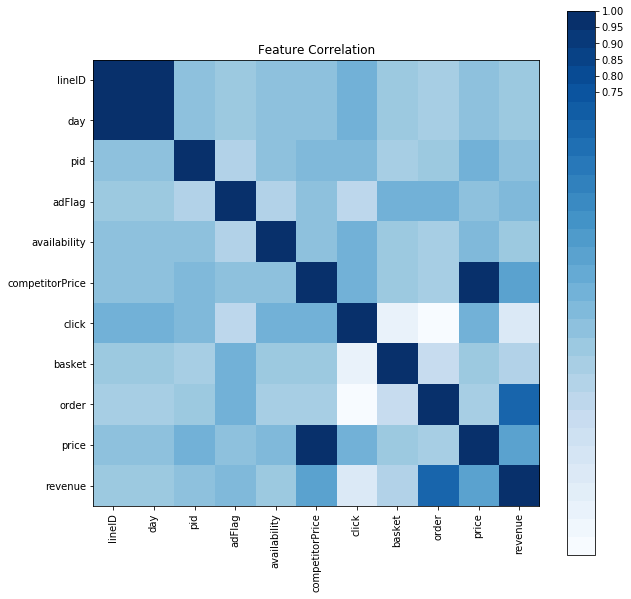

In [6]:
plot_covariance_matrix(df_train)

# Calculate the correlation between competitorPrice and another

In [7]:
df_train.corr()['competitorPrice'].sort_values()

order             -0.076286
basket            -0.049298
adFlag             0.009946
lineID             0.022622
day                0.023958
availability       0.036423
pid                0.096790
click              0.105058
revenue            0.220593
price              0.954357
competitorPrice    1.000000
Name: competitorPrice, dtype: float64

# Prepare training dataset for imputation:
df_train_to_impute: competitorPrice is null


df_train_to_lr: competitorPrice is not null

In [8]:
df_train_to_impute = df_train[df_train.competitorPrice.isnull()].ix[:, ['pid', 'competitorPrice', 'price']]
df_train_to_lr = df_train[df_train.competitorPrice.notnull()].ix[:, ['pid', 'competitorPrice', 'price']]

df_train_to_impute_by_lr: 

df_train_to_impute_by_cluster:

In [9]:
pid_to_imputed_by_lr = list(set(df_train_to_impute.pid.values) & set(df_train_to_lr.pid.values))
pid_to_imputed_by_clusterlr = list(set(df_train_to_impute.pid.values) - set(df_train_to_lr.pid.values))


df_train_to_impute_by_lr = df_train_to_impute[df_train_to_impute.pid.isin(pid_to_imputed_by_lr)]
df_train_to_impute_by_cluster = df_train_to_impute[df_train_to_impute.pid.isin(pid_to_imputed_by_clusterlr)]

# Prepare train/test dataset for Linear regression model

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = \
train_test_split(np.array([df_train_to_lr.price.values]).T, \
                 np.array([df_train_to_lr.competitorPrice.values]).T, \
                 test_size=0.33, \
                 random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1779061, 1)
(1779061, 1)
(876255, 1)
(876255, 1)


# Prepare testing dataset for impuation

In [11]:
seed = np.random.uniform(1, len(set(df_train.pid.values)), len(set(df_train.pid.values))/2)
pid_of_all_null = list(map(lambda x: int(x), seed))
pid_of_not_all_null = [i+1 for i in range(len(set(df_train.pid.values))) if i+1 not in pid_of_all_null]

test_impute_by_lr = df_train_to_lr[df_train_to_lr.pid.isin(pid_of_all_null)]
test_impute_by_clusterlr = df_train_to_lr[df_train_to_lr.pid.isin(pid_of_not_all_null)]

/Users/charlie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


# Fit Linear Regression Model

Coefficients: 
 [[ 0.92172488]]
Mean squared error: 14.26
Variance score: 0.91


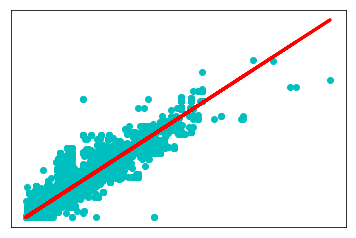

In [12]:
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

# Plot outputs
plt.close()
plt.scatter(X_test, y_test,  color='c')
plt.plot(X_test, regr.predict(X_test), color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

x_test_impute_true_by_lr = np.array([test_impute_by_lr.price]).T
y_test_impute_true_by_lr = np.array([test_impute_by_lr.competitorPrice]).T

y_imputed_pred_by_lr = regr.predict(x_test_impute_true_by_lr)

mse = mean_squared_error(y_imputed_pred_by_lr, y_test_impute_true_by_lr)
mae = mean_absolute_error(y_imputed_pred_by_lr, y_test_impute_true_by_lr)

print("MSE: ", mse)
print("MAE: ", mae)

#x_test_impute_by_clusterlr = np.array([test_impute_by_clusterlr.price]).T
#y_test_impute_by_clusterlr = np.array([test_impute_by_clusterlr.competitorPrice]).T


#regr.predict()

MSE:  14.7111870172
MAE:  1.5810211661


In [15]:
df_train_to_impute[df_train_to_impute.pid.isin(pid_to_imputed_by_lr)]

,pid,competitorPrice,price
63,19317,NaN,3.82
64,9482,NaN,3.34
82,19949,NaN,14.19
118,19317,NaN,3.82
210,2278,NaN,8.91
321,7402,NaN,0.50
351,7722,NaN,6.04
503,2748,NaN,2.48
528,16235,NaN,4.37
576,6182,NaN,8.53


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

x_test_impute_true_by_clusterlr = np.array([test_impute_by_clusterlr.price]).T
y_test_impute_true_by_clusterlr = np.array([test_impute_by_clusterlr.competitorPrice]).T

y_imputed_pred_by_clusterlr = regr.predict(x_test_impute_true_by_clusterlr)

mse = mean_squared_error(y_imputed_pred_by_clusterlr, y_test_impute_true_by_clusterlr)
mae = mean_absolute_error(y_imputed_pred_by_clusterlr, y_test_impute_true_by_clusterlr)

print("MSE: ", mse)
print("MAE: ", mae)

#x_test_impute_by_clusterlr = np.array([test_impute_by_clusterlr.price]).T
#y_test_impute_by_clusterlr = np.array([test_impute_by_clusterlr.competitorPrice]).T


#regr.predict()

MSE:  14.3698279312
MAE:  1.52460644974


In [17]:
df_train_imputed = df_train
df_train_imputed.loc[:, 'competitorPrice'] = regr.predict(np.array([df_train_imputed.loc[:, 'price'].values]).T)

df_train_imputed.to_csv('train_imputed_by_linear_regression.csv')

In [18]:
df_train_imputed

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue
0,1,1,6570,0,2,15.772619,1,0,0,16.89,0.00
1,2,1,14922,1,1,8.269779,0,1,0,8.75,0.00
2,3,1,16382,0,1,15.007587,0,1,0,16.06,0.00
3,4,1,1145,1,1,6.241984,0,0,1,6.55,6.55
4,5,1,3394,0,1,4.020627,0,0,1,4.14,4.14
5,6,1,3661,0,1,9.449586,0,0,1,10.03,10.03
6,7,1,3856,1,1,3.504461,0,0,1,3.58,3.58
7,8,1,16963,0,1,8.269779,1,0,0,8.75,0.00
8,9,1,14560,0,1,11.302253,1,0,0,12.04,0.00
9,10,1,4853,1,1,8.269779,1,0,0,8.75,0.00
